In [29]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
os.chdir(r'C:\Users\Zeke\Documents\Datasets\天池新人实战赛o2o优惠券使用预测')

off_train = pd.read_csv('ccf_offline_stage1_train.csv', keep_default_na=False)
on_train = pd.read_csv('ccf_online_stage1_train.csv', keep_default_na=False)
off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv', keep_default_na=False)

In [13]:
off_train.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,20160217
1,1439408,4663,11002,150:20,1,20160528,null
2,1439408,2632,8591,20:1,0,20160217,null
3,1439408,2632,1078,20:1,0,20160319,null
4,1439408,2632,8591,20:1,0,20160613,null
5,1439408,2632,null,null,0,null,20160516
6,1439408,2632,8591,20:1,0,20160516,20160613
7,1832624,3381,7610,200:20,0,20160429,null
8,2029232,3381,11951,200:20,1,20160129,null
9,2029232,450,1532,30:5,0,20160530,null


In [14]:
off_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        object
Discount_rate    object
Distance         object
Date_received    object
Date             object
dtypes: int64(2), object(5)
memory usage: 93.7+ MB


In [19]:
print('有优惠券，又购买商品',
      off_train[(off_train['Date_received'] != 'null') & (off_train['Date'] != 'null')].shape[0])
print('有优惠券，未购买商品',
      off_train[(off_train['Date_received'] != 'null') & (off_train['Date'] == 'null')].shape[0])
print('无优惠券，购买商品',
      off_train[(off_train['Date_received'] == 'null') & (off_train['Date'] != 'null')].shape[0])
print('无优惠券，未购买商品',
      off_train[(off_train['Date_received'] == 'null') & (off_train['Date'] == 'null')].shape[0])

有优惠券，又购买商品 75382
有优惠券，未购买商品 977900
无优惠券，购买商品 701602
无优惠券，未购买商品 0


In [20]:
print('User_id 在test出现，但未在train出现', set(off_test['User_id']) - set(off_train['User_id']))
print('Merchant_id 在test出现，但未在train出现', set(off_test['Merchant_id']) - set(off_train['Merchant_id']))

User_id 在test出现，但未在train出现 {2495873, 1286474}
Merchant_id 在test出现，但未在train出现 {5920}


**Note**
* 数据中大量购物券未花掉（977900）
* 有很多人购买商品没有用优惠券（701602）
* test中有两个用户是新用户，有一个商铺是新商铺


### 1. 单一字段分析

#### （1）User_id（用户编号）

In [22]:
# 查看训练集有多少用户
len(set(off_train['User_id']))

539438

In [26]:
t = off_train.loc[:,['User_id']]
t['count'] = 1
t = t.groupby(['User_id']).agg('sum').reset_index()
t.sort_values(['count'],ascending=0)[:20]

,User_id,count
370014,5054119,264
201029,2751537,155
215655,2949273,137
487797,6655171,136
354467,4840568,134
486773,6641735,132
290803,3977895,127
382156,5219700,126
395960,5409340,121
215879,2952204,119


In [40]:
def user_count(x):
    if x > 10:
        return 3
    elif x > 5:
        return 2
    elif x > 1:
        return 1
    else:
        return 0

t['user_count'] = t['count'].map(user_count)

t['user_count'].value_counts()

0    241627
1    222075
2     48143
3     27593
Name: user_count, dtype: int64

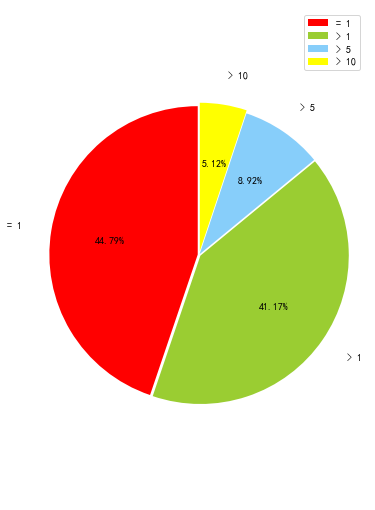

In [39]:
# 画饼图展示用户规律
plt.rcParams['font.sans-serif']=['SimHei'] #解决中文乱码
plt.figure(figsize=(6,9)) #调节图形大小
labels = [u'= 1',u'> 1',u'> 5',u'> 10'] #定义标签
sizes = t['user_count'].value_counts() #每块值
colors = ['red','yellowgreen','lightskyblue','yellow'] #每块颜色定义
explode = (0.01,0.01,0.005,0.025) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      labeldistance = 1.2,#图例距圆心半径倍距离
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = False, #无阴影设置
                      startangle =90, #逆时针起始角度设置
                      pctdistance = 0.6) #数值距圆心半径倍数距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.axis('equal')
plt.legend()
plt.show()

#### （2）Merchant_id（商户编号）

In [41]:
# 查看训练集有多少商户
len(set(off_train['Merchant_id']))

8415

In [43]:
t1 = off_train.loc[:,['Merchant_id']]
t1['count'] = 1
t1 = t1.groupby(['Merchant_id']).agg('sum').reset_index()
t1.sort_values(['count'],ascending=0)[:20]

,Merchant_id,count
3227,3381,142190
424,450,73866
5089,5341,66747
717,760,60280
2800,2934,40645
2586,2709,37085
7191,7555,36916
1492,1569,34518
3368,3532,31578
6163,6485,31218


In [49]:
def Merchant_count(x):
    if x > 1000:
        return 3
    elif x > 100:
        return 2
    elif x > 20:
        return 1
    else:
        return 0

t1['Merchant_count'] = t1['count'].map(Merchant_count)

t1['Merchant_count'].value_counts()

0    4441
1    2818
2    1011
3     145
Name: Merchant_count, dtype: int64

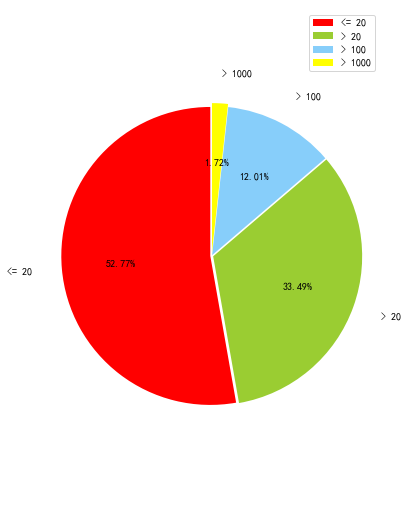

In [50]:
# 画饼图展示商户规律
plt.rcParams['font.sans-serif']=['SimHei'] #解决中文乱码
plt.figure(figsize=(6,9)) #调节图形大小
labels = [u'<= 20',u'> 20',u'> 100',u'> 1000'] #定义标签
sizes = t1['Merchant_count'].value_counts() #每块值
colors = ['red','yellowgreen','lightskyblue','yellow'] #每块颜色定义
explode = (0.01,0.01,0.005,0.025) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      labeldistance = 1.2,#图例距圆心半径倍距离
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = False, #无阴影设置
                      startangle =90, #逆时针起始角度设置
                      pctdistance = 0.6) #数值距圆心半径倍数距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.axis('equal')
plt.legend()
plt.show()

### (3) Coupon_id 

In [51]:
print('有优惠券的数据为', off_train[(off_train['Coupon_id'] != 'null')].shape[0])
print('无优惠券的数据为', off_train[(off_train['Coupon_id'] == 'null')].shape[0])

有优惠券的数据为 1053282
无优惠券的数据为 701602


In [53]:
t2 = off_train.loc[:,['Coupon_id']]
t2 = t2[(t2['Coupon_id'] != 'null')]
t2['count'] = 1
t2 = t2.groupby(['Coupon_id']).agg('sum').reset_index()
t2.sort_values(['count'],ascending=0)[:20]

,Coupon_id,count
7883,7610,46729
3876,2418,29284
1518,11951,26035
8622,8555,26009
3175,1480,24815
3412,1807,24500
842,111,21760
4181,2840,21693
5881,5054,21402
3105,14031,21059


In [54]:
def Coupon_count(x):
    if x > 1000:
        return 3
    elif x > 100:
        return 2
    elif x > 20:
        return 1
    else:
        return 0

t2['Coupon_count'] = t2['count'].map(Merchant_count)

t2['Coupon_count'].value_counts()

0    7124
1    1978
2     504
3     132
Name: Coupon_count, dtype: int64

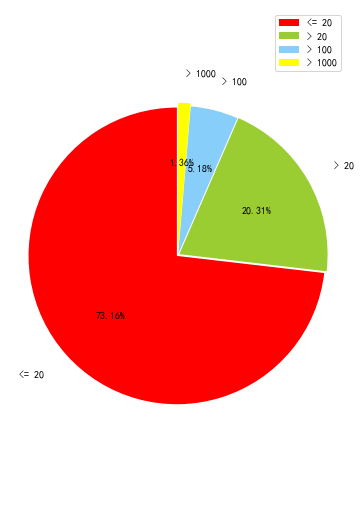

In [56]:
# 画饼图展示商户规律
plt.rcParams['font.sans-serif']=['SimHei'] #解决中文乱码
plt.figure(figsize=(6,9)) #调节图形大小
labels = [u'<= 20',u'> 20',u'> 100',u'> 1000'] #定义标签
sizes = t2['Coupon_count'].value_counts() #每块值
colors = ['red','yellowgreen','lightskyblue','yellow'] #每块颜色定义
explode = (0.01,0.01,0.005,0.025) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      labeldistance = 1.2,#图例距圆心半径倍距离
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = False, #无阴影设置
                      startangle =90, #逆时针起始角度设置
                      pctdistance = 0.6) #数值距圆心半径倍数距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.axis('equal')
plt.legend()
plt.show()